In [1]:
# 引入一些包
import os
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np

In [2]:
# 指定Excel文件所在的文件夹路径
folder_path = 'C:/Users/F7910/Desktop/LDA_database/data'

# 获取文件夹中所有Excel文件的文件名
excel_files = [file for file in os.listdir(folder_path) if file.endswith('.xlsx') or file.endswith('.xls')]

# 创建一个空的DataFrame，用于存储所有Excel数据
all_data = pd.DataFrame()

# 循环遍历每个Excel文件并读取数据
for file in excel_files:
    # 构建完整的文件路径
    file_path = os.path.join(folder_path, file)
    
    # 使用pandas的read_excel函数读取Excel文件并将其转换为DataFrame
    excel_data = pd.read_excel(file_path)
    
    # 将当前Excel文件的数据追加到总体数据中
    all_data = pd.concat([all_data, excel_data], ignore_index=True)

In [3]:
# 引入文件及分词

Tingyong = open('C:\\Users\\F7910\Desktop\\LDA_database\\TingYongCi\\Tingyong.txt', encoding='gbk')
file_path = 'C:\\Users\\F7910\\Desktop\\LDA_database\\CiQianRu\\glove_2.txt'

output_path = 'C:\\Users\\F7910\\Desktop\\LDA2024\\output'
os.chdir(output_path)

# 构建人工停用词典 Tingyong_1
Tingyong_1=[]
for line in Tingyong:
    Tingyong_1.append(line.strip())


# 分词操作
def english_word_cut(mytext):
    cutwords1 = word_tokenize(mytext)
    cutwords1 = [word.lower() for word in cutwords1]
    cutwords2 = [word for word in cutwords1 if word not in Tingyong_1]
    stops = set(stopwords.words("english"))
    cutwords3 = [word for word in cutwords2 if word not in stops]
    cutwords3 = [word for word in cutwords3 if word.isalpha()]
    word_list = []
    for word in cutwords3:
        word_list.append(word)      
    return (" ").join(word_list)

# 检查并处理 "Abstract" 列中的非字符串值和缺失值
all_data["Abstract"] = all_data["Abstract"].apply(lambda x: str(x) if pd.notna(x) else "")

all_data["Abstract"] = all_data.Abstract.apply(english_word_cut)

######################
corpus_tokenized = [doc.split() for doc in all_data["Abstract"]]


In [4]:
# 引入词向量及哈希表
data_cqr_1 = pd.read_csv(file_path,sep=' ',on_bad_lines='skip',header=0,engine="python")
data_cqr_1 = data_cqr_1.transpose()  # 转置
data_cqr_1.columns = data_cqr_1.iloc[0]  # 将第一行设置为列名
data_cqr_1 = data_cqr_1.drop(data_cqr_1.index[0]) # 删除第一行
data_cqr_2 = data_cqr_1.values # 只取数字（只保留列向量）
# emb_matrix_l = data_cqr_2.astype(float) # 将向量值变成浮点类型
# emb_matrix_h = emb_matrix_l.T # 转置变成行向量
# 列表套列表 其中每一列表是分好词的一篇文章

# 哈希
def build_hash_table(lst):
    hash_table = {}
    for i, s in enumerate(lst):
        hash_table[s] = i
    return hash_table
def search_in_hash_table(hash_table, s):
    if s in hash_table:
        return hash_table[s]
    else:
        return -1
def get_string_from_hash_table(hash_table, index):
    for key, value in hash_table.items():
        if value == index:
            return key
    # return None
str_list = list(data_cqr_1.columns)
# 构建哈希表
hash_table_1 = build_hash_table(str_list)

cqr_all_1 = set(data_cqr_1.columns)
data_all_2 = []
for cen in all_data["Abstract"]:
    for ci in cen.split():
        data_all_2.append(ci)
data_all_3 = set(data_all_2)

str_list = list(data_cqr_1.columns)

data_cqr_3 = [word for word in str_list if str(word).isalpha()]
ind = []
for word in data_cqr_3:
    ind.append(search_in_hash_table(hash_table_1,word))
cqr_f_1 = np.take(data_cqr_2,ind,axis=1).astype(float)

In [5]:
# 导入lda相关包
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
from gensim.models.ldamulticore import LdaMulticore

In [6]:
# 导入k-means相关包
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

c:\python\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


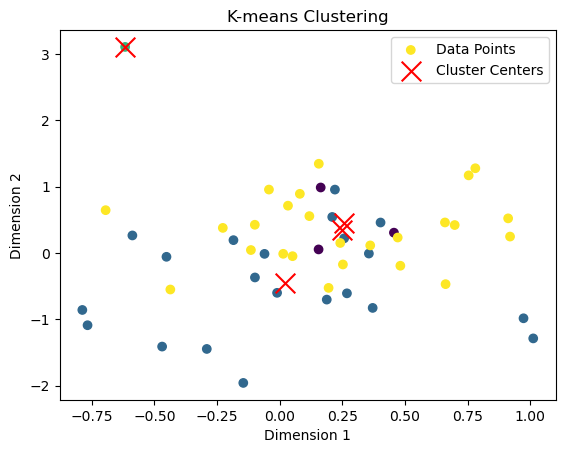

In [7]:
# 主体循环
np.random.seed(8)

topic_num = []
coherence_score = []
perplexity_score = []
silhouette_avg = []
ch_score = []
db_score = []

for topic in range(4,20):
    topic_n = topic
    # 创建 LDA 主题模型
    dictionary = Dictionary(corpus_tokenized)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_tokenized]
    lda_model = LdaModel(corpus=corpus_bow,    # 语料库
                        num_topics=topic_n,   # 主题数
                        id2word=dictionary,   # 词典，将单词转换为数字索引
                        iterations=100,  # 迭代次数
                        chunksize = 50,
                        # 在训练LDA模型时，语料库需要被切割成多少个块。每个块都会被用于训练LDA模型中的一次迭代
                        passes=5,     # 训练时语料库需要被重复遍历的次数
                        random_state = 2
                        )

    # 计算主题一致性
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=corpus_tokenized, 
                                     dictionary=dictionary, 
                                     coherence='c_v',
                                     window_size = 30
                                    )

    # 计算主题困惑度
    perplexity_score.append(lda_model.log_perplexity(chunk = corpus_bow))


    topic_num.append(topic)
    coherence_score.append(coherence_model.get_coherence())

    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
    pyLDAvis.display(vis)
    pyLDAvis.save_html(vis, 'lda_pass' + str(topic_n)+'.html')


    
    t = []
    import re
    for idx,topic in lda_model.show_topics(num_topics=-1):
        for w in topic.split():
            # print(w)
            letters_only = re.sub(r'[^a-zA-Z]', '', w)
            # print(letters_only)
            t.append(letters_only)
    t = list(filter(None,t))

    ind_k = []
    for word in t:
        ind_k.append(search_in_hash_table(hash_table_1,word))
    cqr_f_k = np.take(data_cqr_2,ind_k,axis=1).astype(float)
    
    data = cqr_f_k

    # 创建一个K-means模型，假设你想要将数据聚类成簇
    kmeans = KMeans(n_clusters=topic_n, n_init='auto')

    # 将模型拟合到数据
    kmeans.fit(data)

    # 获取簇中心和标签
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # 可视化数据点和簇中心
    plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis', marker='o', label='Data Points')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title('K-means Clustering')

    file_name = 'k_means_clustering_{}.png'.format(topic_n)  
    plt.savefig(file_name)

    plt.show()

    # Evaluate clustering performance
    silhouette_avg.append(silhouette_score(data, kmeans.labels_))
    ch_score.append(calinski_harabasz_score(data, kmeans.labels_))
    db_score.append(davies_bouldin_score(data, kmeans.labels_))

In [ ]:
# 绘制coherence_score
x = topic_num
y = coherence_score
# 创建折线图
plt.plot(x, y, label='coherence_score')
# 添加标签和标题
plt.xlabel('topic_num')
plt.ylabel('coherence_score')
plt.title('coherence_score')
# 添加图例
plt.legend()
# 显示图形
plt.show()

In [ ]:
# 绘制perplexity_score
x = topic_num
y = [np.exp(-perplexity) for perplexity in perplexity_score]
# 创建折线图
plt.plot(x, y, label='perplexity_score')
# 添加标签和标题
plt.xlabel('topic_num')
plt.ylabel('perplexity_score')
plt.title('Perplexity Score')
# 添加图例
plt.legend()
# 显示图形
plt.show()

In [ ]:
# 绘制silhouette_avg
x = topic_num
y = silhouette_avg
# 创建折线图
plt.plot(x, y, label='silhouette_avg')
# 添加标签和标题
plt.xlabel('topic_num')
plt.ylabel('silhouette_avg')
plt.title('silhouette_avg')
# 添加图例
plt.legend()
# 显示图形
plt.show()

In [ ]:
# 绘制ch_score
x = topic_num
y = ch_score
# 创建折线图
plt.plot(x, y, label='ch_score')
# 添加标签和标题
plt.xlabel('topic_num')
plt.ylabel('ch_score')
plt.title('ch_score')
# 添加图例
plt.legend()
# 显示图形
plt.show()